In [1]:
%pylab inline
from utils import *
from ipdb import set_trace
import numpy as np
import torch
import os
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch import autograd
# from torch.autograd import Variable
import nibabel as nib
from torch.utils.data.dataset import Dataset
from torch.utils.data import dataloader
from nilearn import plotting
from ADNI_dataset import *
from BRATS_dataset import *
from ATLAS_dataset import *
from Model_alphaWGAN import *
from Model_VAEGAN import Encoder
from utils import sinkhorn_pointcloud as sp

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [2]:
BATCH_SIZE=4
gpu = True
workers = 4

LAMBDA= 10
_eps = 1e-15
Use_BRATS=False
Use_ATLAS = False

#setting latent variable sizes
latent_dim = 1000

gpu_0 = 1
gpu_1 = 1
torch_seed = 4
r_g = torch.manual_seed(torch_seed)
checkpoint_pth = 'wl_checkpoint_2'

In [3]:
dataset = ADNIdataset(augmentation=True, img_size=64)
# trainset, testset = data.random_split(dataset, [5, 5], generator=r_g)
train_loader = torch.utils.data.DataLoader(dataset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)
# test_loader = torch.utils.data.DataLoader(testset,batch_size=BATCH_SIZE,
#                                           shuffle=True,num_workers=workers)
# if Use_BRATS:
#     #'flair' or 't2' or 't1ce'
#     trainset = BRATSdataset(imgtype='flair')
#     train_loader = torch.utils.data.DataLoader(trainset,batch_size = BATCH_SIZE, shuffle=True,
#                                                num_workers=workers)
# if Use_ATLAS:
#     trainset = ATLASdataset(augmentation=True)
#     train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
#                                           shuffle=True,num_workers=workers)

In [4]:
def inf_train_gen(data_loader):
    while True:
        for _,images in enumerate(data_loader):
            yield images

In [5]:
G = Generator(noise = latent_dim)
CD = Code_Discriminator(code_size = latent_dim ,num_units = 4096)
D = Discriminator(is_dis=True)
# E = Encoder(gpu_ind=gpu_0)
E = Discriminator(out_class = latent_dim,is_dis=False, img_size=128)

G.cuda(gpu_0)
D.cuda(gpu_0)
CD.cuda(gpu_1)
E.cuda(gpu_1)

Discriminator(
  (conv1): Conv3d(1, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv3d(256, 512, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn4): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv3d(512, 1000, kernel_size=(4, 4, 4), stride=(1, 1, 1))
)

In [6]:
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
e_optimizer = optim.Adam(E.parameters(), lr = 0.0002)
cd_optimizer = optim.Adam(CD.parameters(), lr = 0.0002)

In [7]:
def calc_gradient_penalty(model, x, x_gen, w=10, cuda_ind=0):
    """WGAN-GP gradient penalty"""
    assert x.size()==x_gen.size(), "real and sampled sizes do not match"
    alpha_size = tuple((len(x), *(1,)*(x.dim()-1)))
    alpha_t = torch.cuda.FloatTensor if x.is_cuda else torch.Tensor
    alpha = alpha_t(*alpha_size).uniform_().cuda(cuda_ind)
    #x_hat = x.data*alpha + x_gen.data*(1-alpha)
    x_hat = x*alpha + x_gen*(1-alpha)
    # x_hat = Variable(x_hat, requires_grad=True)
    x_hat.requires_grad = True

    def eps_norm(x):
        x = x.view(len(x), -1)
        return (x*x+_eps).sum(-1).sqrt()
    def bi_penalty(x):
        return (x-1)**2
    grad_xhat = torch.autograd.grad(model(x_hat).sum(), x_hat, create_graph=True, only_inputs=True)[0]

    penalty = w*bi_penalty(eps_norm(grad_xhat)).mean()
    return penalty

# Training

In [8]:
torch.autograd.set_detect_anomaly(True)
#remove Variable usage
# real_y = torch.ones((BATCH_SIZE, 1)).cuda()#async=True))
# fake_y = torch.zeros((BATCH_SIZE, 1)).cuda()#async=True))

criterion_bce = nn.BCELoss()
criterion_l1 = nn.L1Loss()
criterion_mse = nn.MSELoss()

In [9]:
# load the highest savepoints of all models
df = load_loss(path=checkpoint_pth)
iteration = load_checkpoint(G, D, E, None, '_iter', path=checkpoint_pth)

In [10]:
g_iter = 1
d_iter = 3
cd_iter =1
TOTAL_ITER = 200000
gen_load = inf_train_gen(train_loader)
test_load = inf

lossStr [68500/200000]
        D: -3.78   
        En_Ge: 2.32e+02


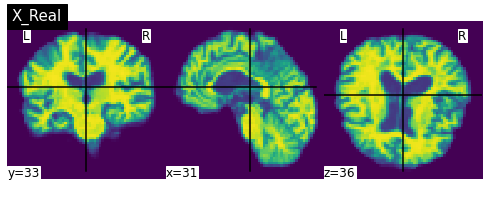

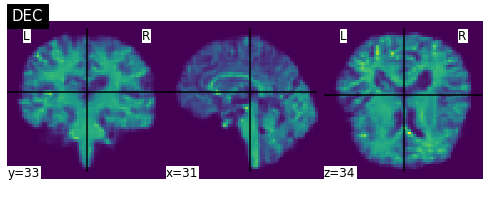

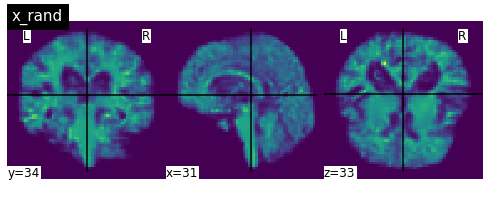

<Figure size 432x288 with 0 Axes>

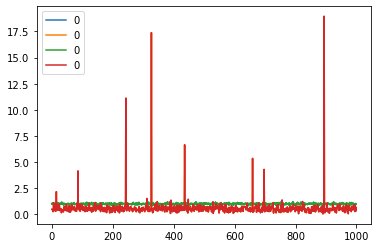

index: 68500, sample_mean: -0.042053915560245514 sample_var: 1.3982667922973633, yellow_mean: -0.0019499813206493855 yellow_var: 0.9972323179244995


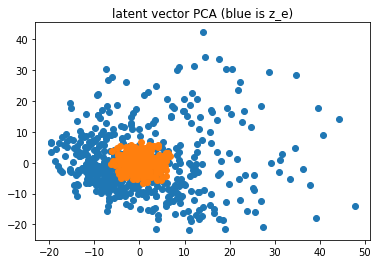

index: 68500, sample_mean: -0.8678111433982849 sample_var: 0.0512680783867836, yellow_mean: -0.8596851825714111 yellow_var: 0.055685855448246


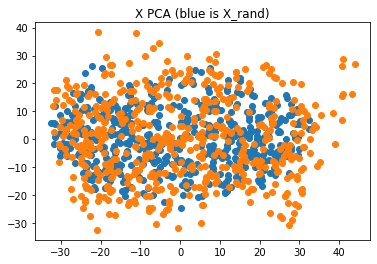

lossStr [68600/200000]
        D: -8.07   
        En_Ge: 2.34e+02


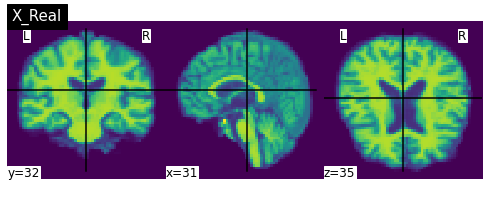

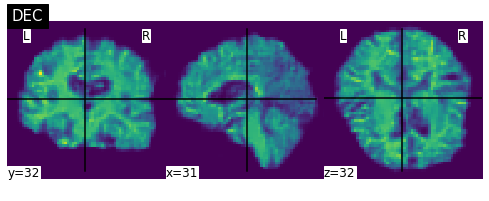

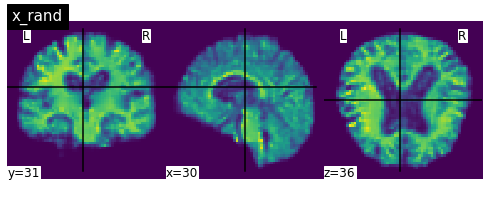

lossStr [68700/200000]
        D: -15.1   
        En_Ge: 2.04e+02


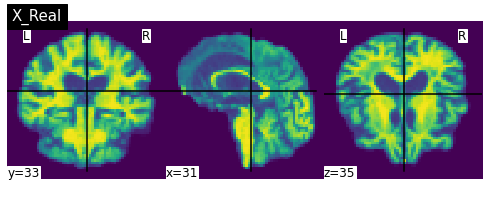

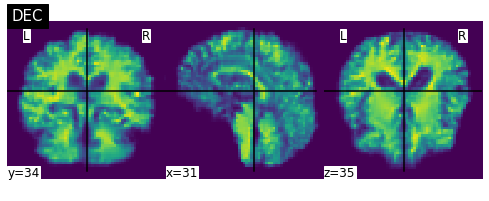

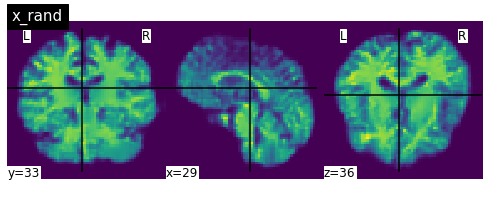

lossStr [68800/200000]
        D: -15.5   
        En_Ge: 2.54e+02


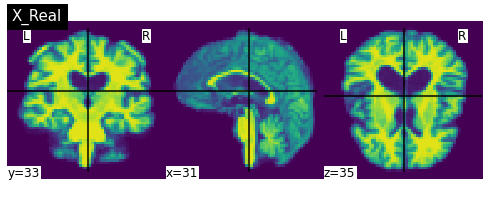

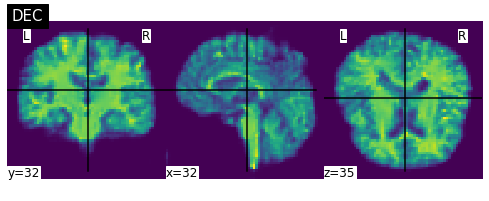

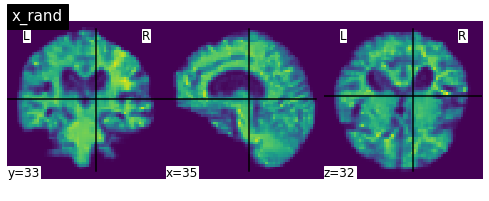

lossStr [68900/200000]
        D: 1.14    
        En_Ge: 2.22e+02


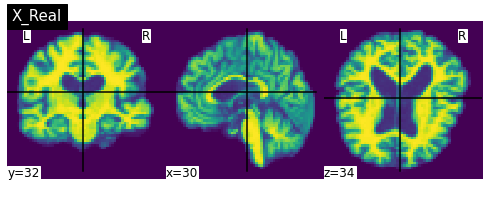

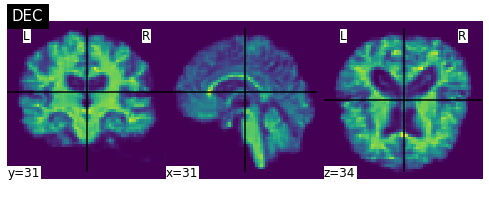

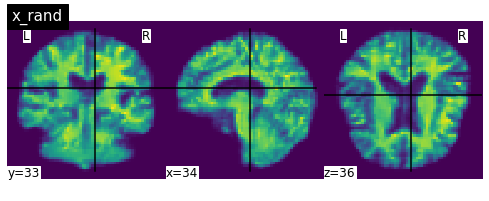

<Figure size 432x288 with 0 Axes>

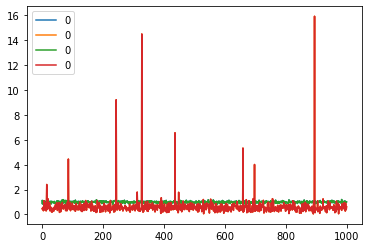

index: 69000, sample_mean: 0.14318259060382843 sample_var: 1.7264376878738403, yellow_mean: 6.609631236642599e-05 yellow_var: 0.9971572160720825


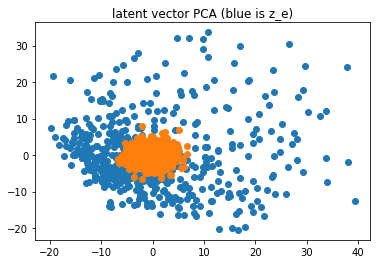

index: 69000, sample_mean: -0.8617371320724487 sample_var: 0.05561893433332443, yellow_mean: -0.8587280511856079 yellow_var: 0.05631910264492035


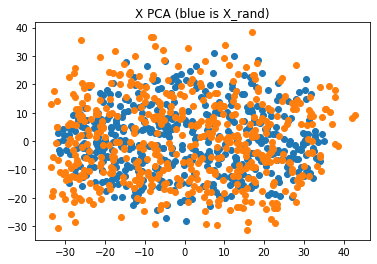

lossStr [69100/200000]
        D: -6.86   
        En_Ge: 2.58e+02


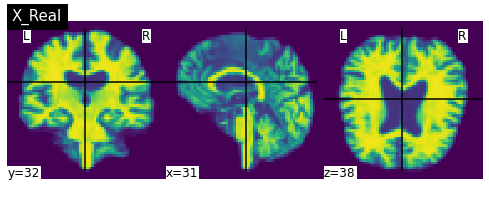

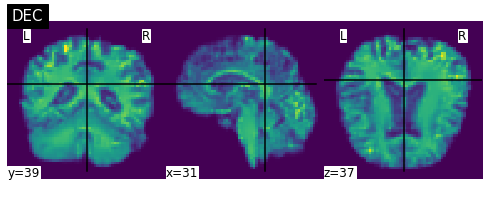

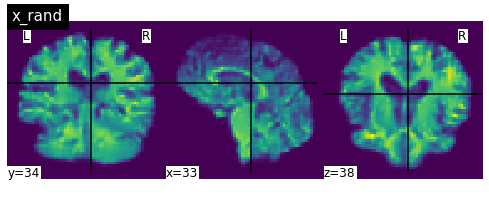

lossStr [69200/200000]
        D: -20.4   
        En_Ge: 2.11e+02


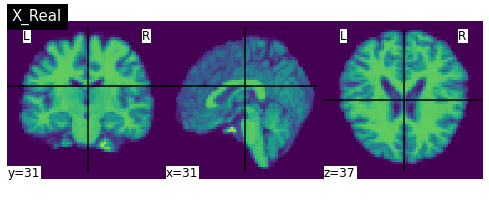

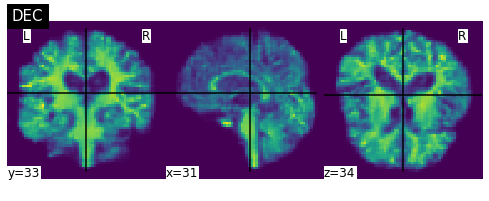

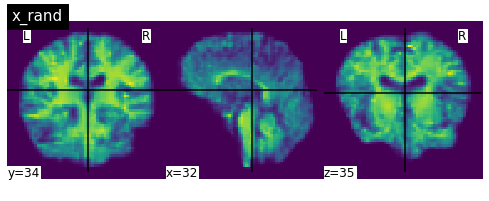

lossStr [69300/200000]
        D: -13.0   
        En_Ge: 2.13e+02


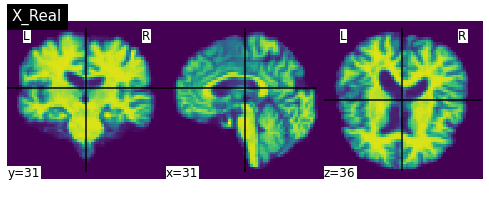

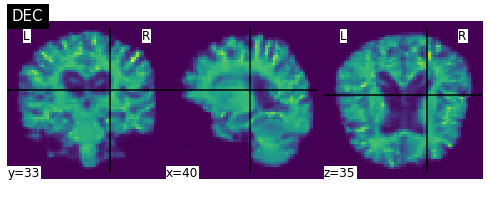

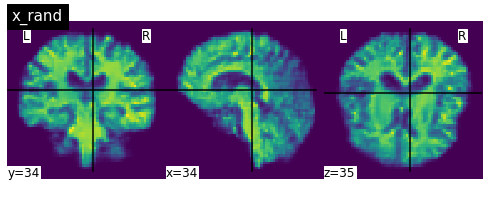

lossStr [69400/200000]
        D: -17.4   
        En_Ge: 2.39e+02


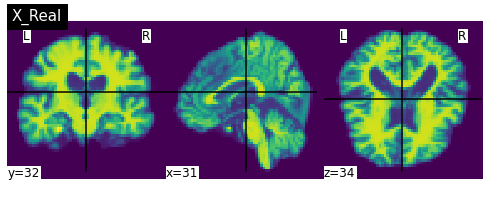

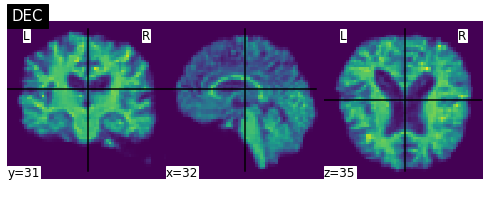

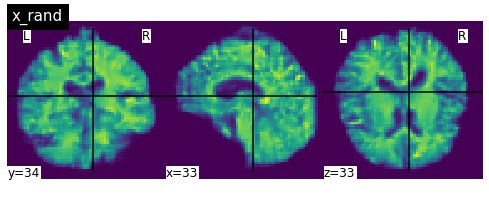

lossStr [69500/200000]
        D: -61.9   
        En_Ge: 2.7e+02 


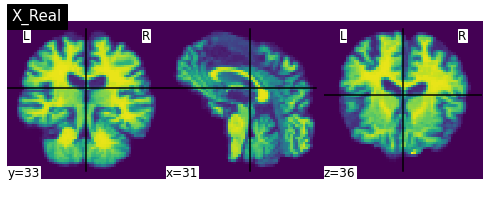

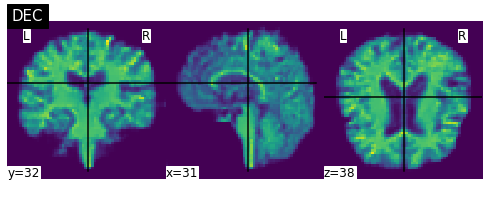

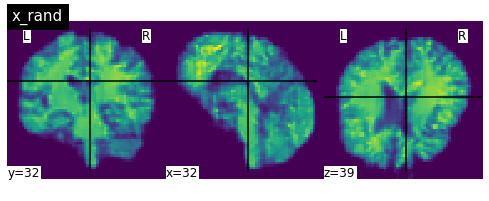

<Figure size 432x288 with 0 Axes>

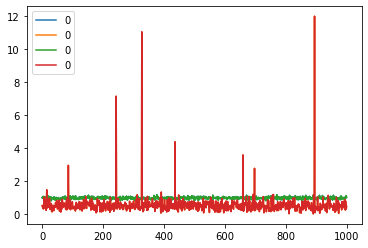

index: 69500, sample_mean: 0.12396540492773056 sample_var: 1.4063732624053955, yellow_mean: 0.0010778800351545215 yellow_var: 0.9969293475151062


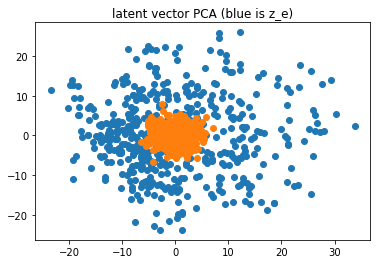

index: 69500, sample_mean: -0.8580435514450073 sample_var: 0.057358309626579285, yellow_mean: -0.8595207929611206 yellow_var: 0.055964577943086624


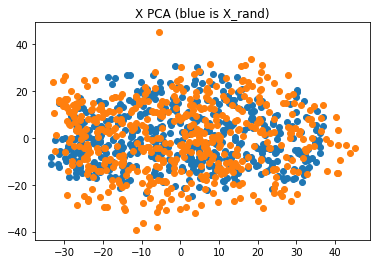

lossStr [69600/200000]
        D: -12.3   
        En_Ge: 2.37e+02


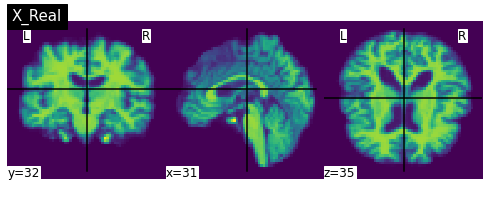

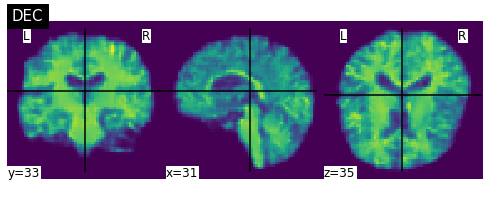

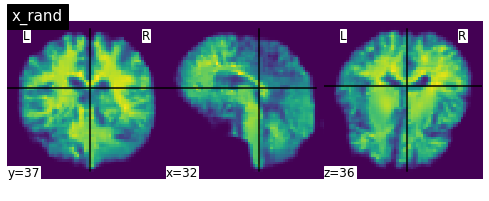

lossStr [69700/200000]
        D: 13.5    
        En_Ge: 2.28e+02


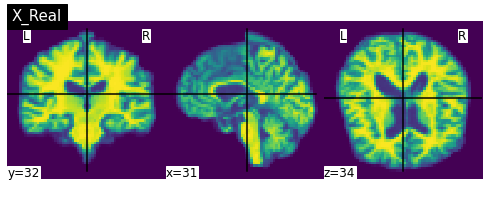

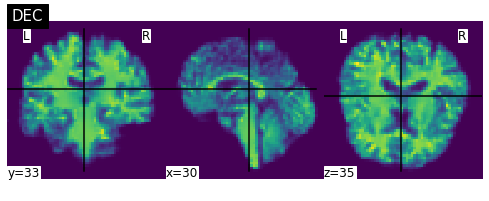

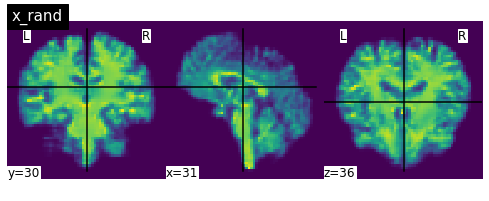

lossStr [69800/200000]
        D: -21.0   
        En_Ge: 2.74e+02


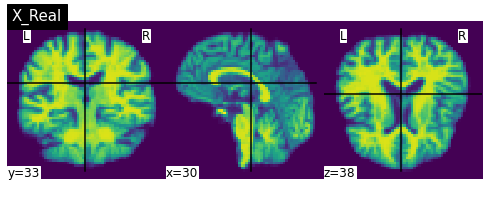

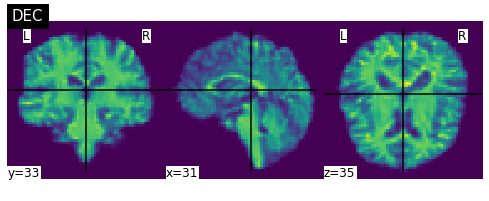

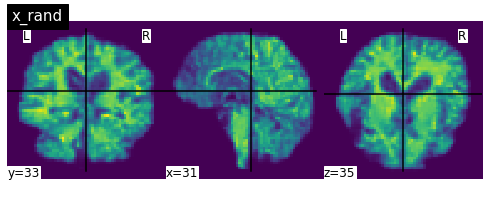

lossStr [69900/200000]
        D: -18.3   
        En_Ge: 1.61e+02


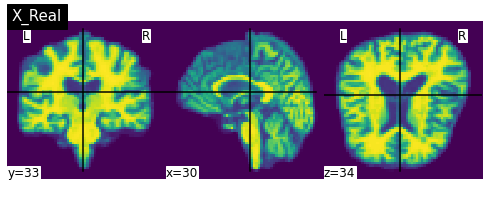

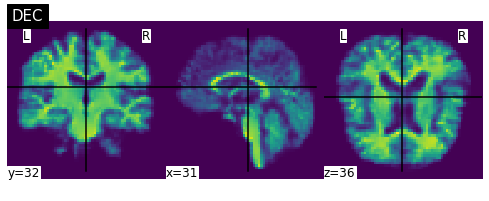

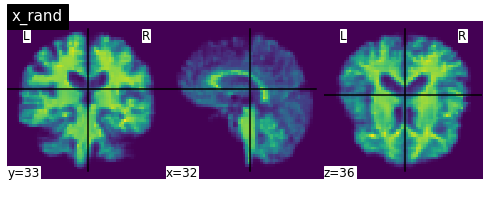

lossStr [70000/200000]
        D: -11.0   
        En_Ge: 2.59e+02


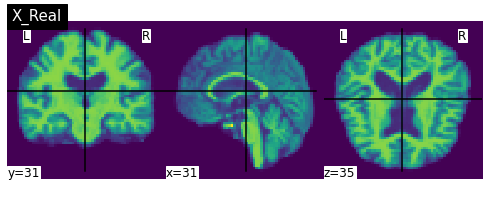

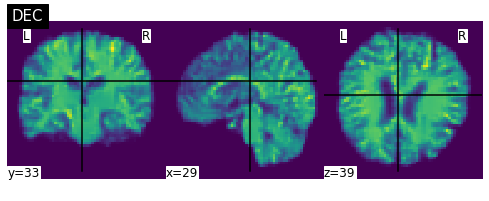

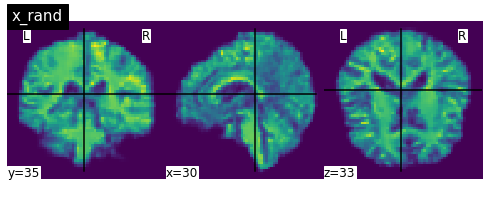

<Figure size 432x288 with 0 Axes>

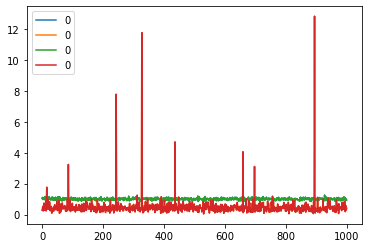

index: 70000, sample_mean: -0.5396842956542969 sample_var: 2.0138022899627686, yellow_mean: 0.0014456636272370815 yellow_var: 1.0015983581542969


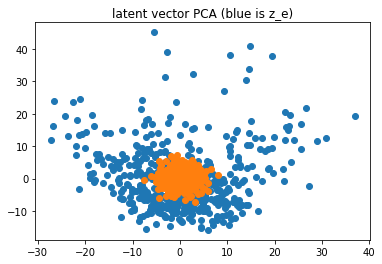

index: 70000, sample_mean: -0.8532798290252686 sample_var: 0.060114361345767975, yellow_mean: -0.8588570952415466 yellow_var: 0.0564730241894722


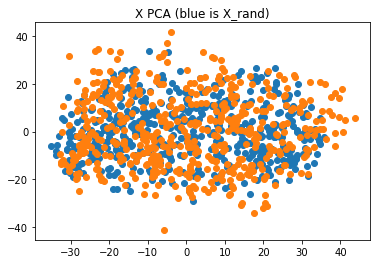

lossStr [70100/200000]
        D: -7.85   
        En_Ge: 2.14e+02


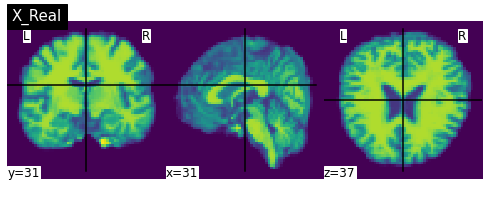

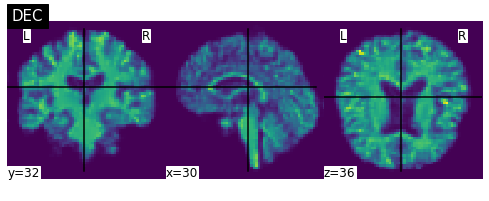

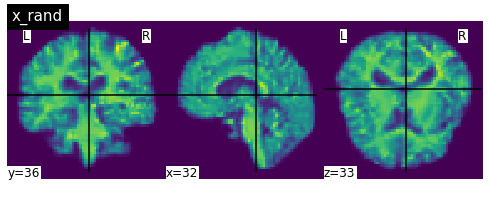

lossStr [70200/200000]
        D: -9.69   
        En_Ge: 1.96e+02


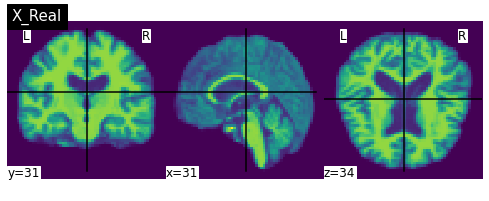

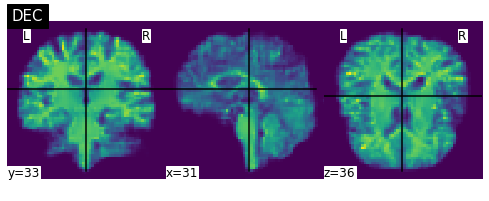

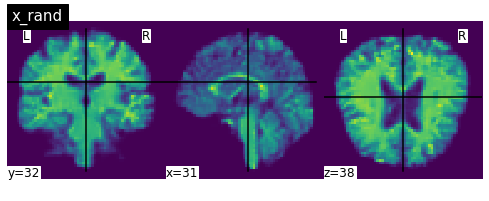

lossStr [70300/200000]
        D: -10.7   
        En_Ge: 2.38e+02


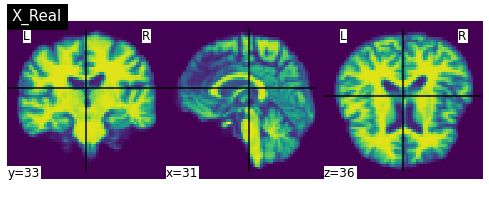

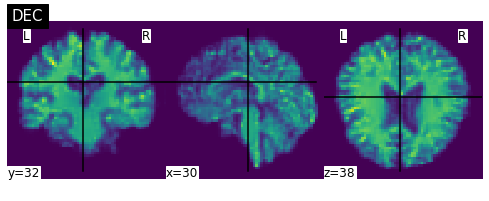

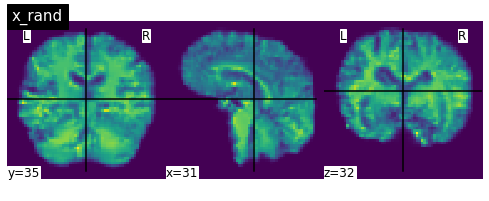

lossStr [70400/200000]
        D: 1.72    
        En_Ge: 1.95e+02


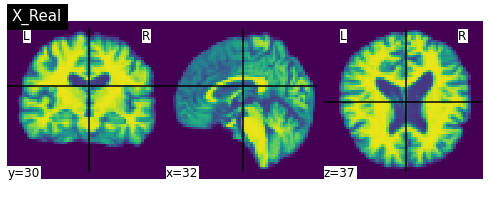

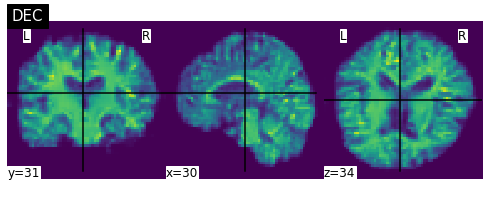

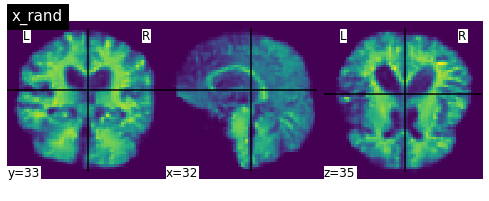

lossStr [70500/200000]
        D: -2.69   
        En_Ge: 2.03e+02


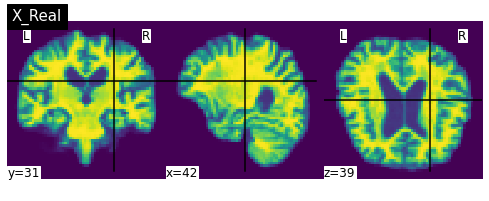

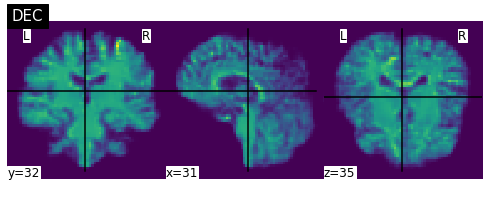

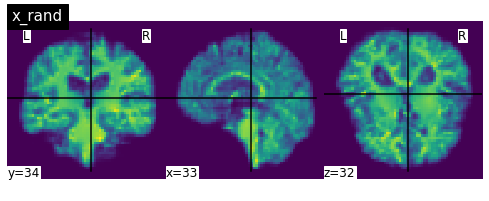

<Figure size 432x288 with 0 Axes>

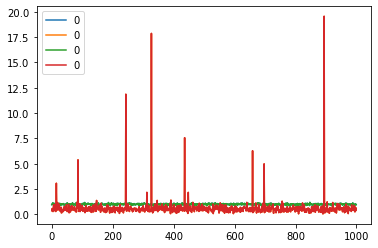

index: 70500, sample_mean: 0.033807024359703064 sample_var: 1.1363253593444824, yellow_mean: 0.00202352786436677 yellow_var: 1.000288486480713


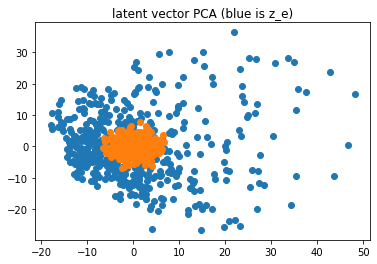

index: 70500, sample_mean: -0.8630276918411255 sample_var: 0.05244871973991394, yellow_mean: -0.858562707901001 yellow_var: 0.05657155439257622


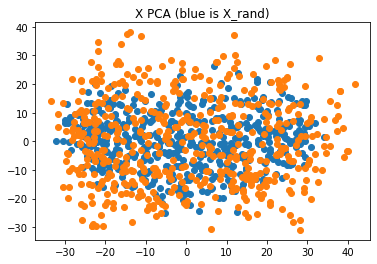

lossStr [70600/200000]
        D: -5.83   
        En_Ge: 2e+02   


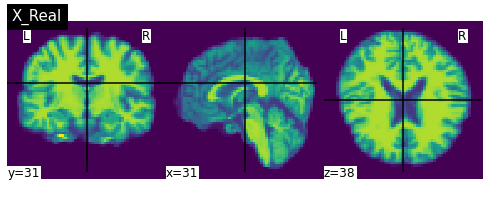

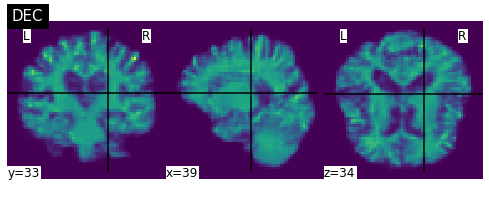

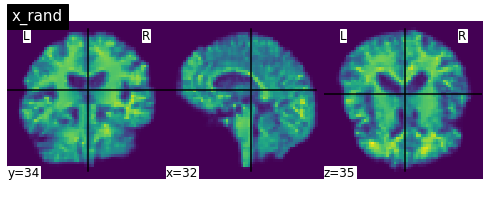

lossStr [70700/200000]
        D: -10.9   
        En_Ge: 2.16e+02


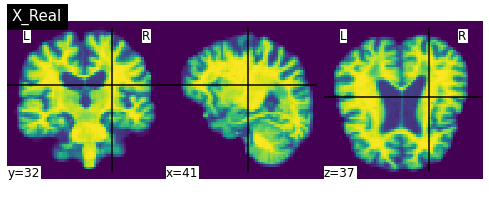

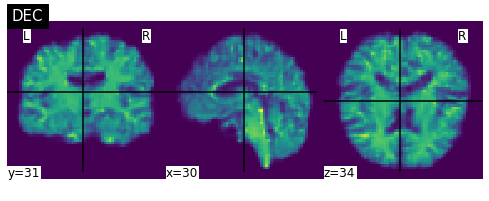

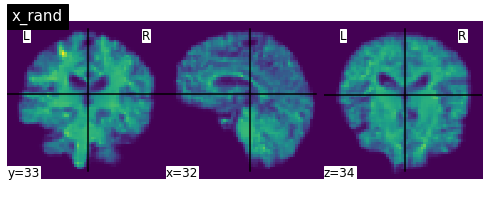

lossStr [70800/200000]
        D: -9.0    
        En_Ge: 1.94e+02


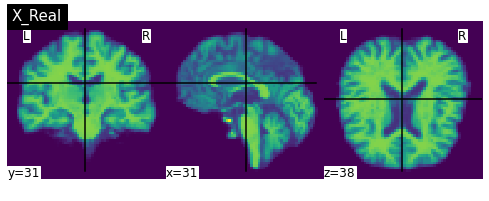

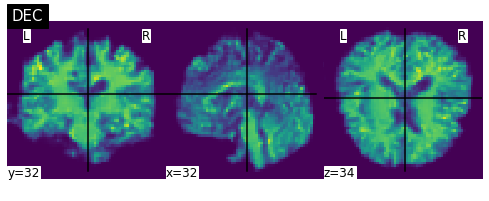

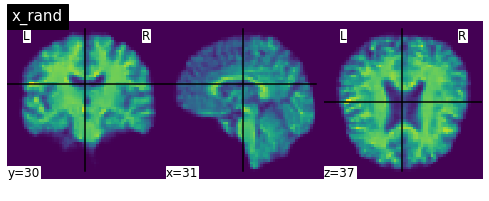

lossStr [70900/200000]
        D: -10.5   
        En_Ge: 2.26e+02


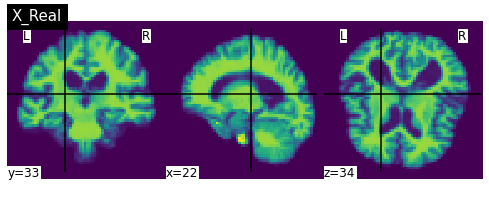

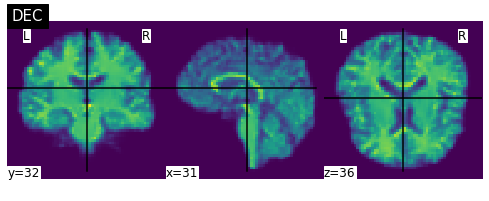

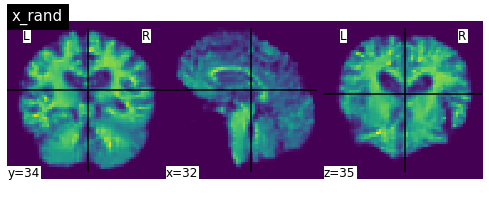

lossStr [71000/200000]
        D: -14.4   
        En_Ge: 2.08e+02


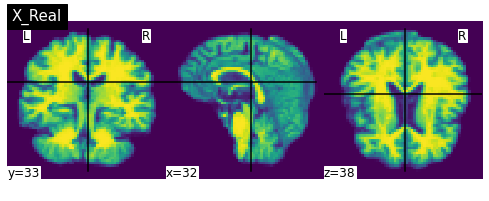

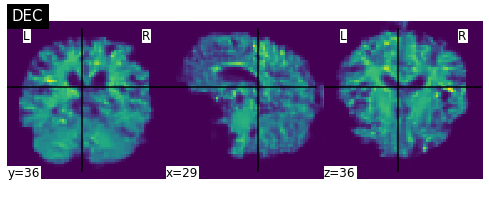

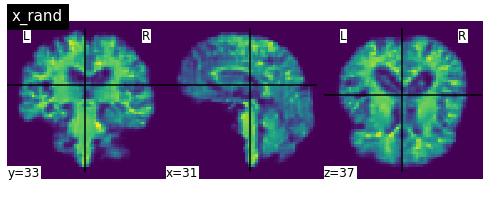

<Figure size 432x288 with 0 Axes>

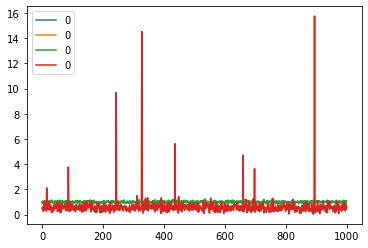

index: 71000, sample_mean: 0.00480352807790041 sample_var: 1.2523846626281738, yellow_mean: 0.0014997769612818956 yellow_var: 1.0016448497772217


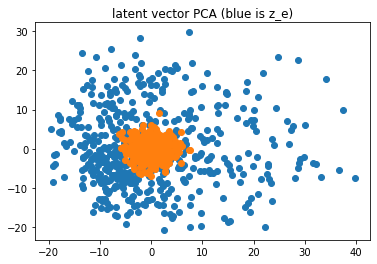

index: 71000, sample_mean: -0.8663834929466248 sample_var: 0.0521799698472023, yellow_mean: -0.8592066764831543 yellow_var: 0.05619502440094948


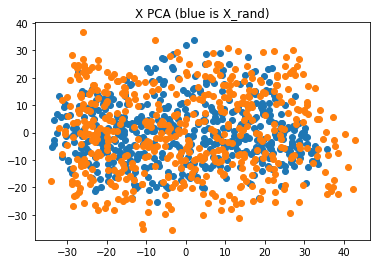

lossStr [71100/200000]
        D: -9.02   
        En_Ge: 2.07e+02


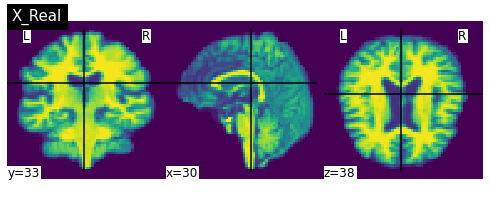

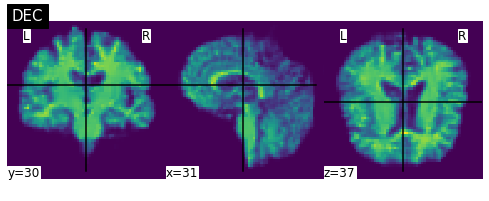

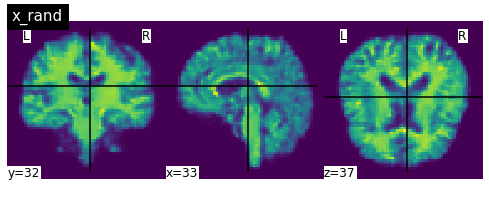

lossStr [71200/200000]
        D: -16.7   
        En_Ge: 1.92e+02


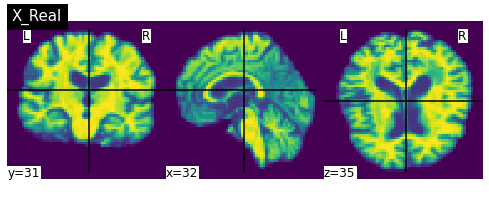

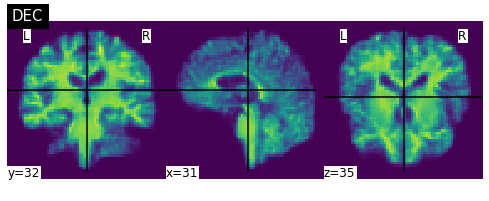

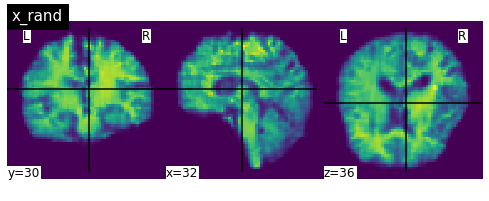

lossStr [71300/200000]
        D: -16.1   
        En_Ge: 2.42e+02


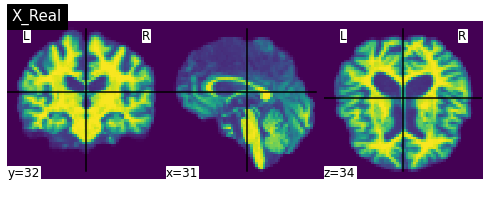

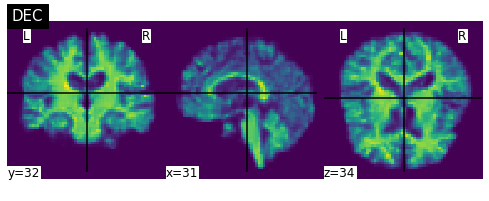

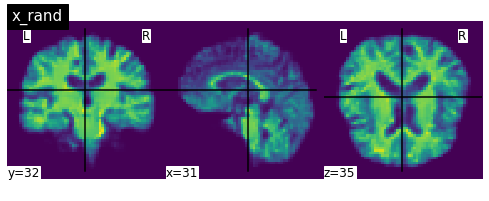

lossStr [71400/200000]
        D: -33.4   
        En_Ge: 1.87e+02


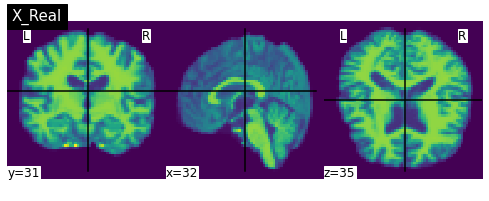

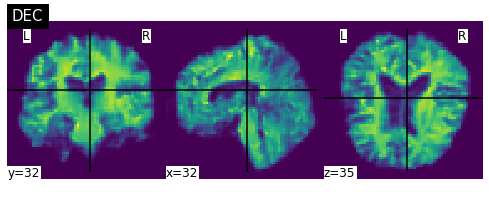

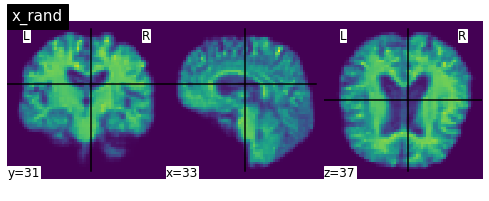

lossStr [71500/200000]
        D: -8.92   
        En_Ge: 2.06e+02


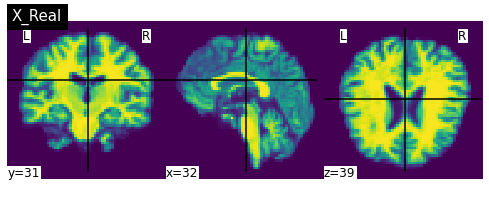

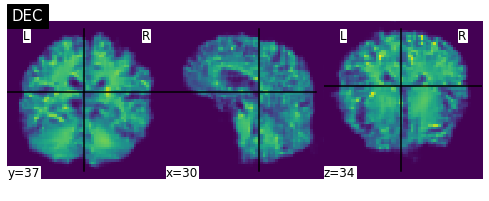

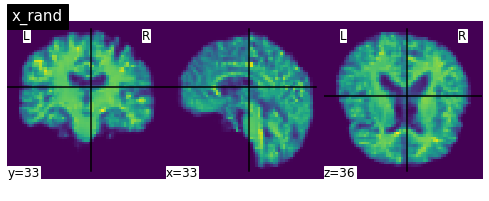

<Figure size 432x288 with 0 Axes>

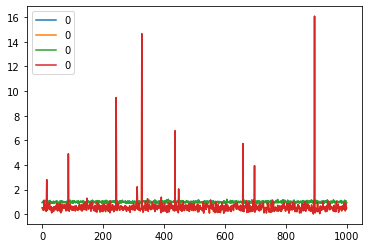

index: 71500, sample_mean: 0.02090081013739109 sample_var: 1.5221035480499268, yellow_mean: 0.0015989525709301233 yellow_var: 0.9993194341659546


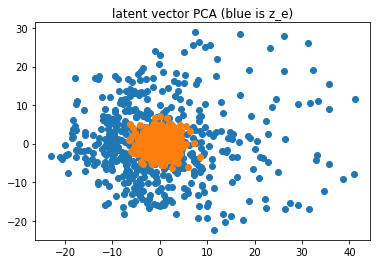

index: 71500, sample_mean: -0.8608335256576538 sample_var: 0.0566905215382576, yellow_mean: -0.8589395880699158 yellow_var: 0.056225817650556564


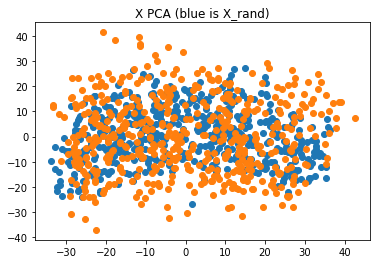

lossStr [71600/200000]
        D: -13.0   
        En_Ge: 2.21e+02


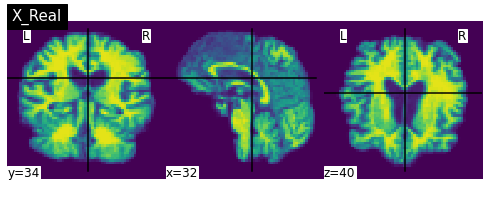

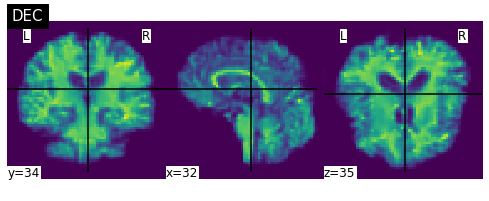

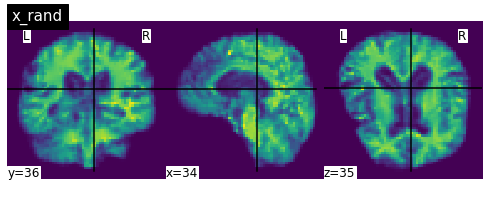

lossStr [71700/200000]
        D: -3.45   
        En_Ge: 2.18e+02


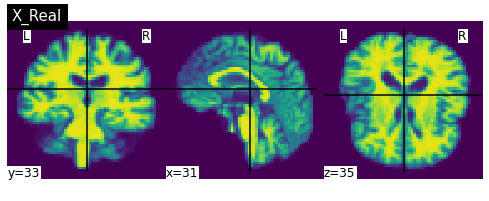

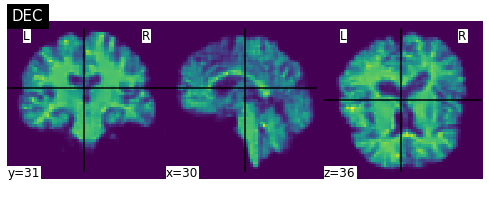

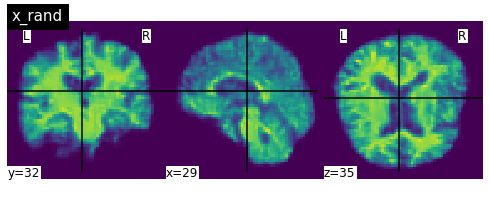

lossStr [71800/200000]
        D: -22.7   
        En_Ge: 2.49e+02


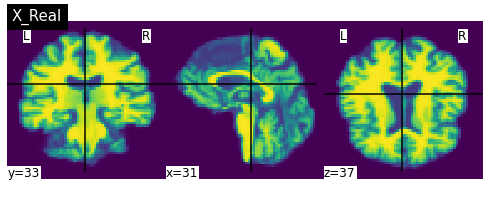

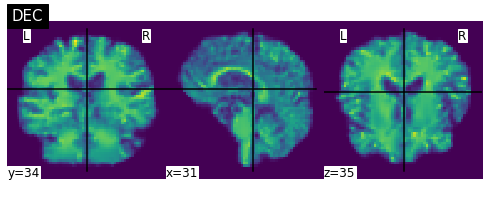

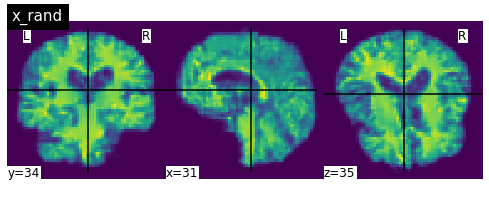

lossStr [71900/200000]
        D: -11.0   
        En_Ge: 2.2e+02 


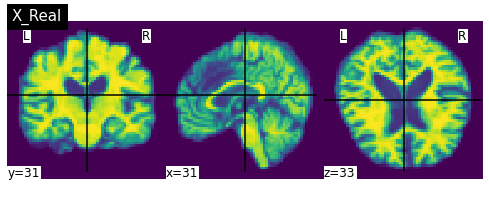

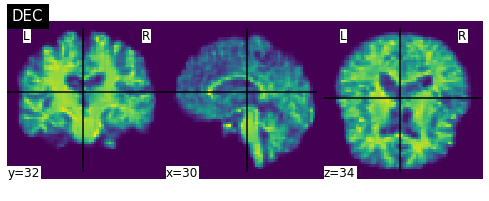

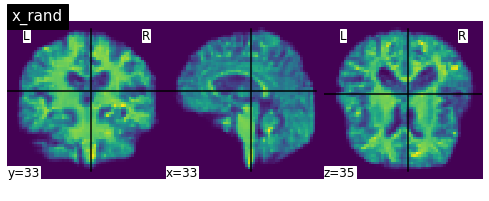

lossStr [72000/200000]
        D: -47.1   
        En_Ge: 2.01e+02


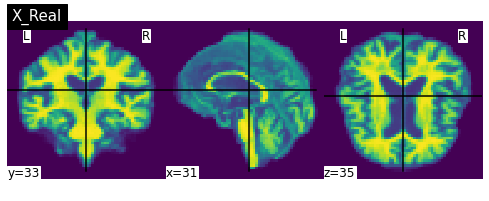

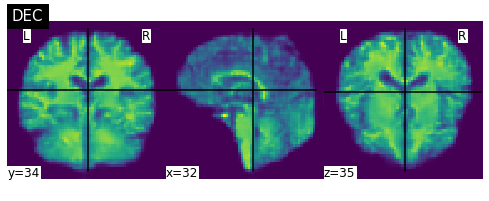

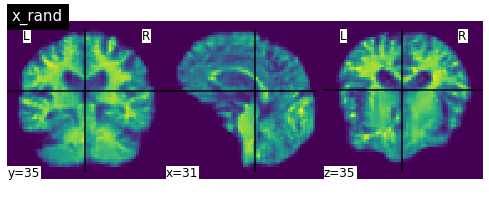

<Figure size 432x288 with 0 Axes>

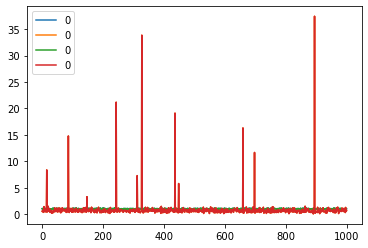

index: 72000, sample_mean: 0.1580747663974762 sample_var: 1.7443909645080566, yellow_mean: -0.0009898387361317873 yellow_var: 1.0034046173095703


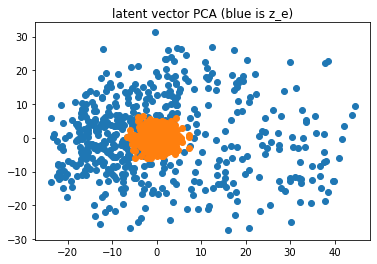

index: 72000, sample_mean: -0.8677352666854858 sample_var: 0.047600120306015015, yellow_mean: -0.8585981726646423 yellow_var: 0.05645141750574112


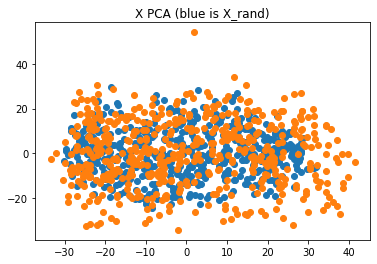

lossStr [72100/200000]
        D: -4.89   
        En_Ge: 2.07e+02


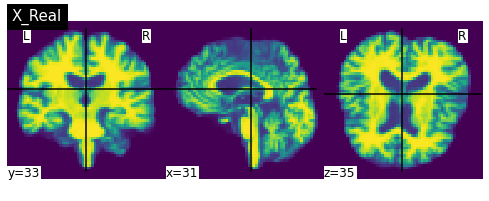

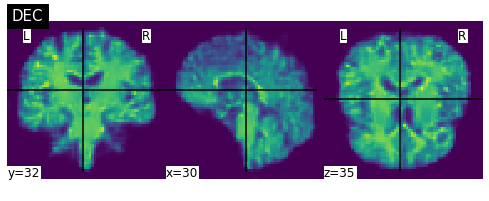

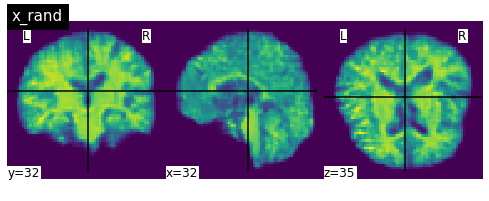

lossStr [72200/200000]
        D: -36.6   
        En_Ge: 1.86e+02


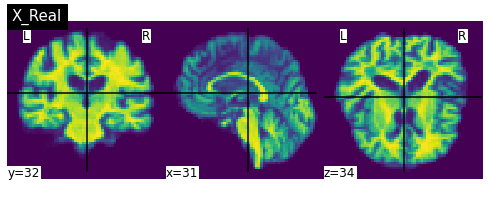

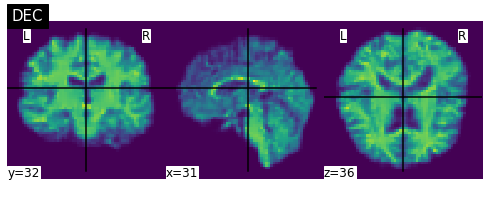

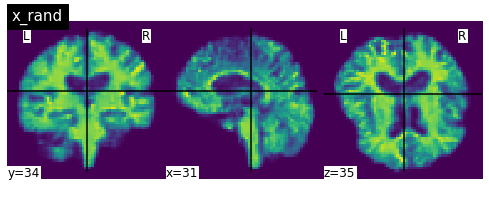

lossStr [72300/200000]
        D: -36.5   
        En_Ge: 1.63e+02


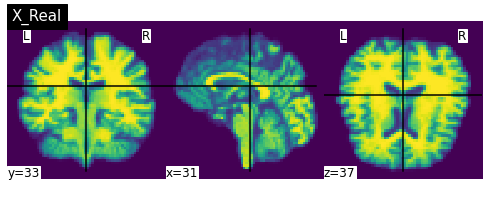

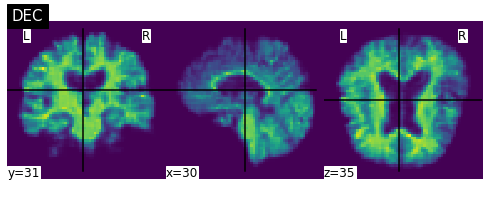

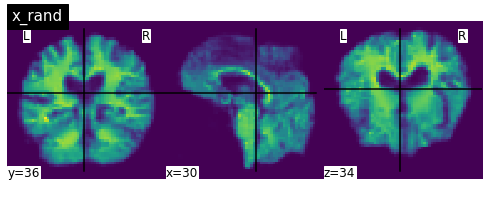

lossStr [72400/200000]
        D: -4.24   
        En_Ge: 2.27e+02


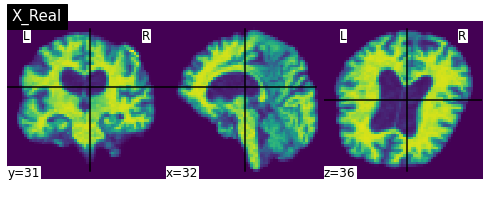

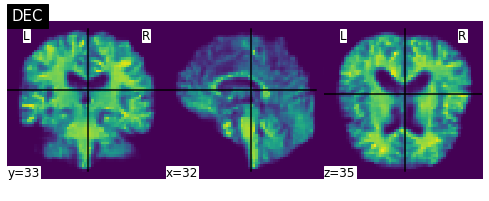

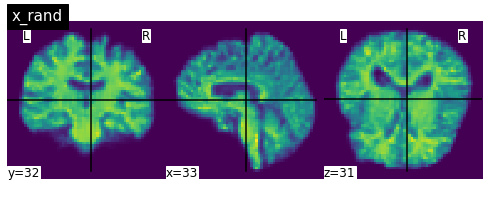

lossStr [72500/200000]
        D: -32.5   
        En_Ge: 2.28e+02


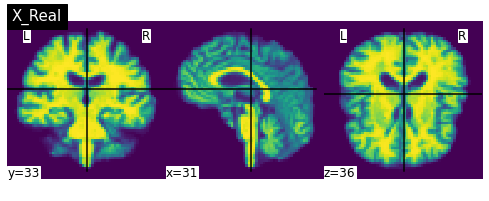

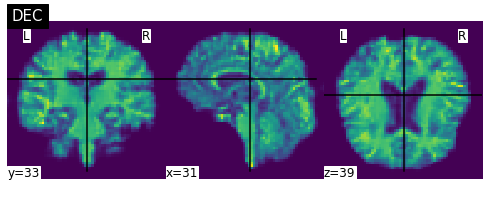

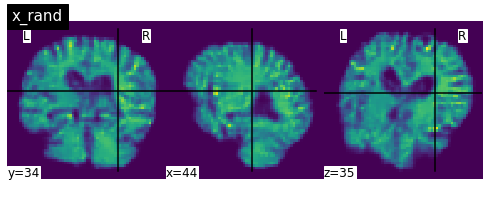

<Figure size 432x288 with 0 Axes>

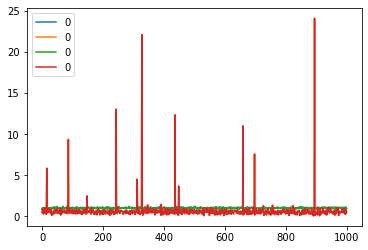

index: 72500, sample_mean: 0.05207592993974686 sample_var: 1.3810187578201294, yellow_mean: -0.002574669662863016 yellow_var: 1.0025055408477783


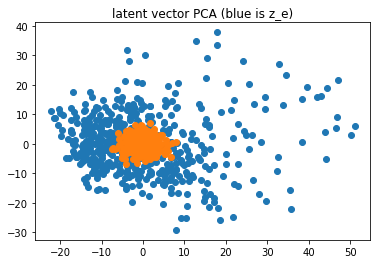

index: 72500, sample_mean: -0.8454450964927673 sample_var: 0.06521785259246826, yellow_mean: -0.8586661219596863 yellow_var: 0.056558847427368164


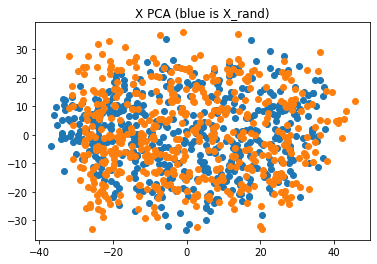

lossStr [72600/200000]
        D: -25.3   
        En_Ge: 2.28e+02


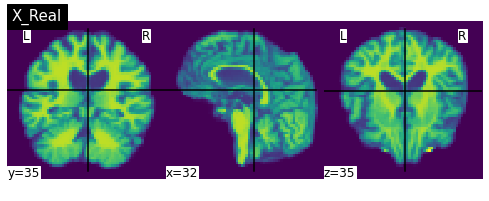

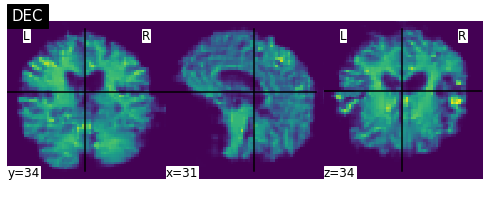

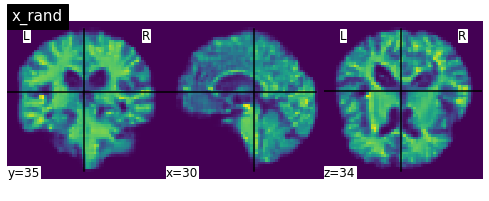

lossStr [72700/200000]
        D: -17.8   
        En_Ge: 1.74e+02


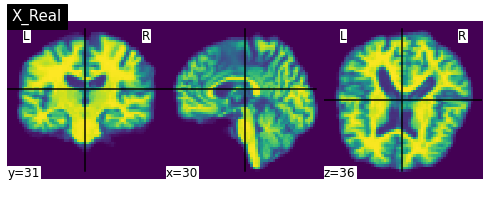

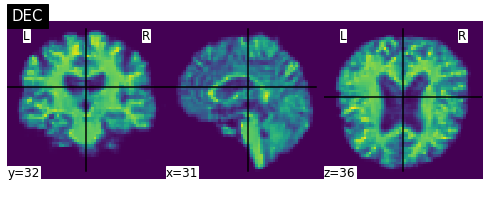

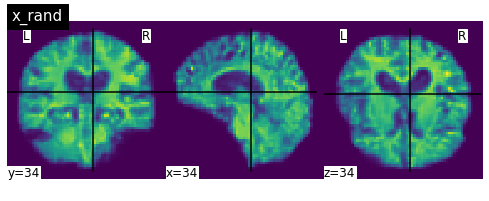

lossStr [72800/200000]
        D: 4.0     
        En_Ge: 2.45e+02


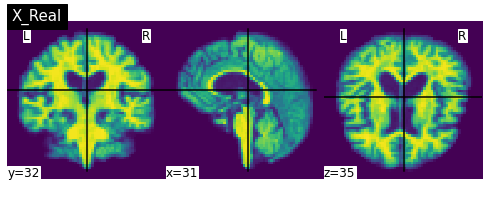

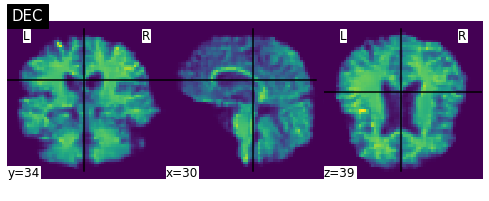

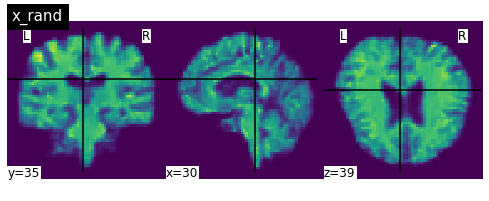

lossStr [72900/200000]
        D: -10.2   
        En_Ge: 1.95e+02


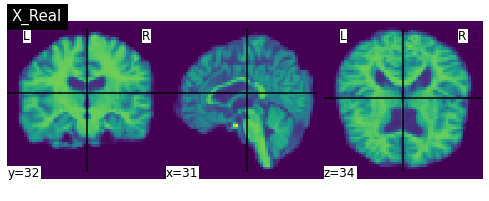

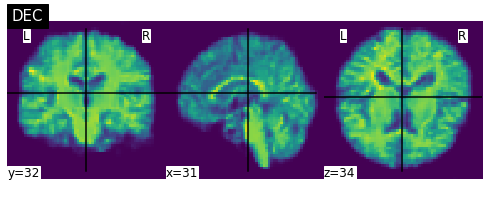

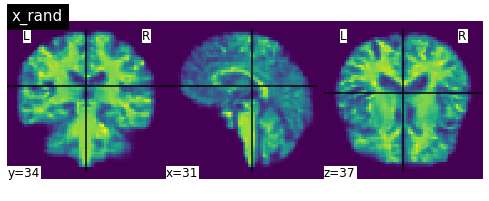

lossStr [73000/200000]
        D: -7.26   
        En_Ge: 1.97e+02


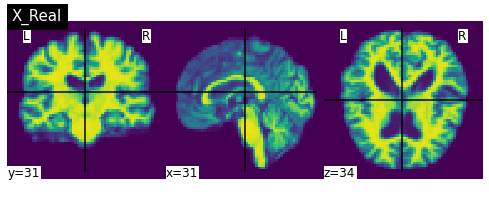

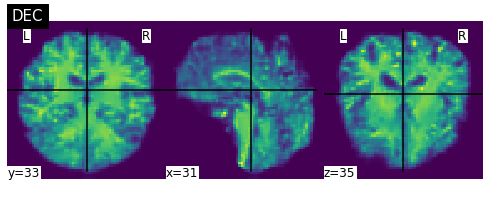

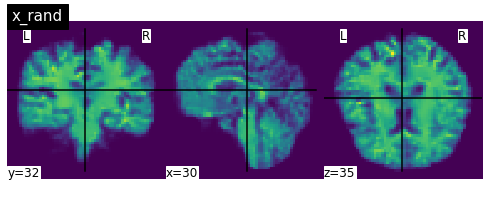

<Figure size 432x288 with 0 Axes>

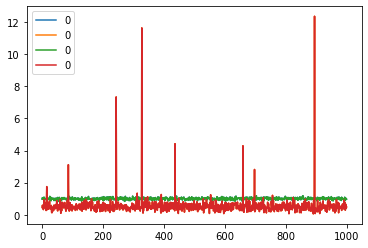

index: 73000, sample_mean: 0.13745519518852234 sample_var: 1.5767877101898193, yellow_mean: 0.001905379118397832 yellow_var: 1.0008273124694824


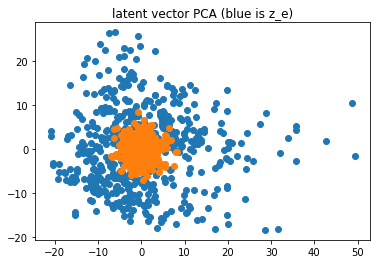

index: 73000, sample_mean: -0.8602207899093628 sample_var: 0.05556192994117737, yellow_mean: -0.8587137460708618 yellow_var: 0.0563342347741127


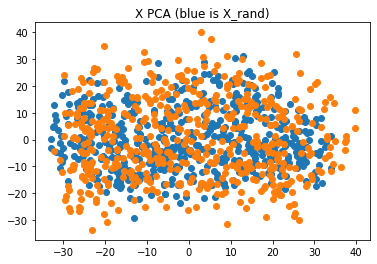

lossStr [73100/200000]
        D: -17.0   
        En_Ge: 2.1e+02 


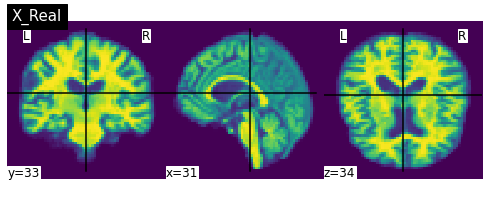

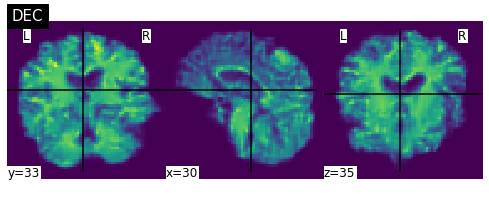

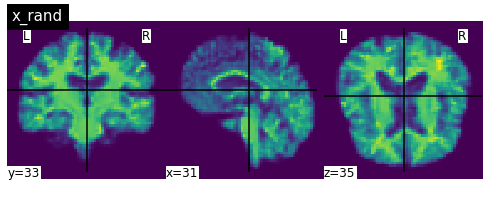

lossStr [73200/200000]
        D: -35.9   
        En_Ge: 1.96e+02


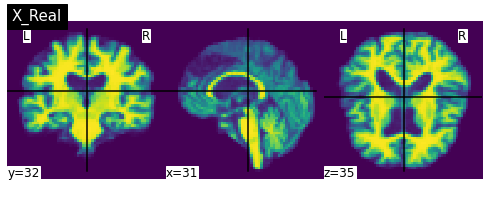

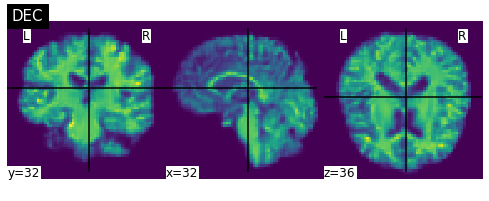

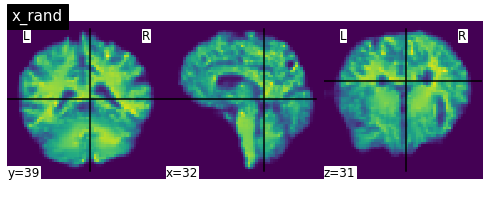

lossStr [73300/200000]
        D: -0.623  
        En_Ge: 1.73e+02


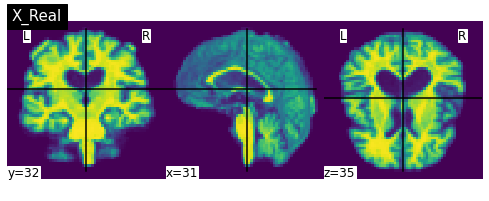

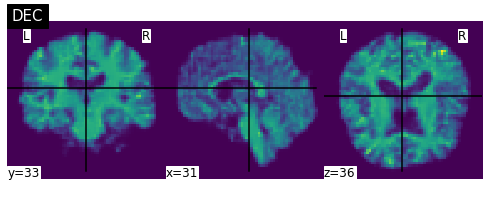

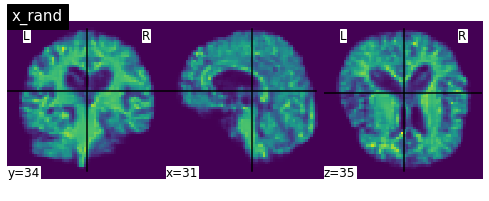

lossStr [73400/200000]
        D: -0.552  
        En_Ge: 1.86e+02


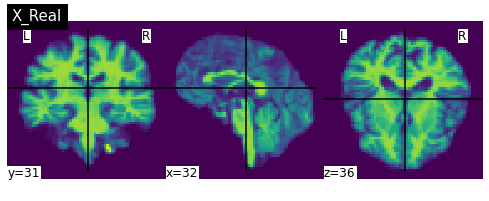

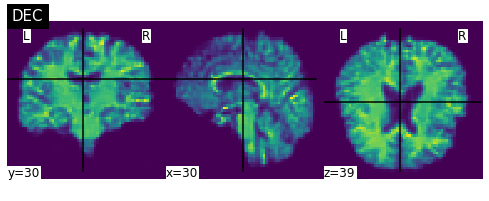

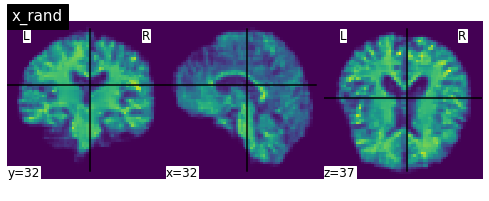

lossStr [73500/200000]
        D: -4.21   
        En_Ge: 1.85e+02


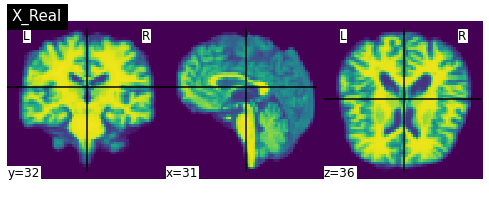

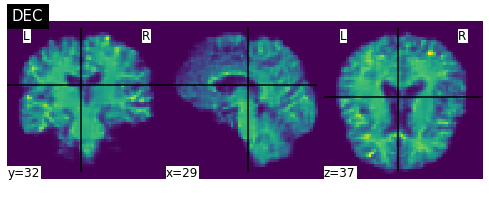

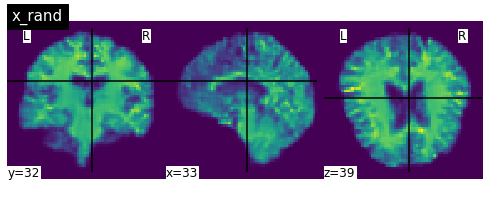

<Figure size 432x288 with 0 Axes>

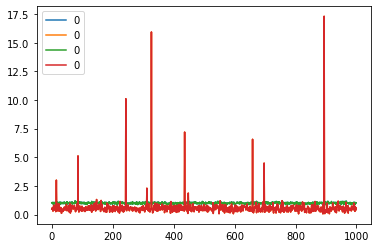

index: 73500, sample_mean: 0.0814628154039383 sample_var: 1.3399147987365723, yellow_mean: 0.0011586572509258986 yellow_var: 1.003530502319336


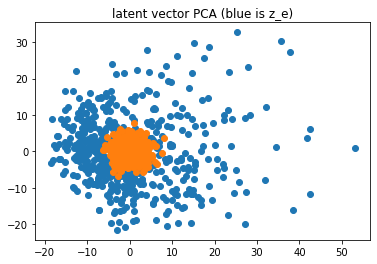

index: 73500, sample_mean: -0.8550554513931274 sample_var: 0.0614192970097065, yellow_mean: -0.8603228330612183 yellow_var: 0.05525198578834534


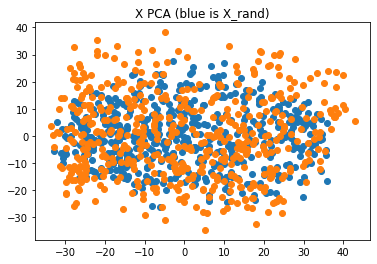

lossStr [73600/200000]
        D: -2.26   
        En_Ge: 1.91e+02


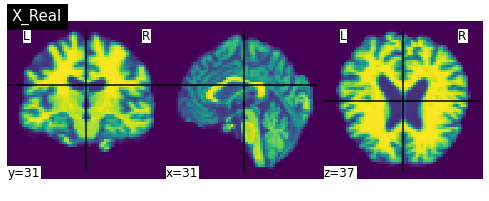

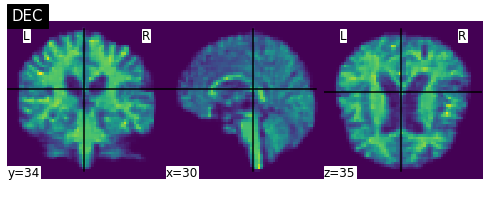

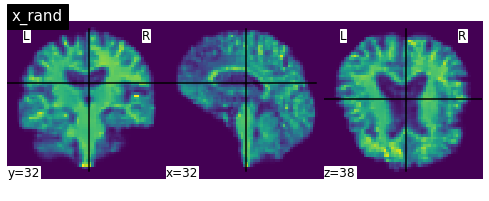

lossStr [73700/200000]
        D: -5.32   
        En_Ge: 1.93e+02


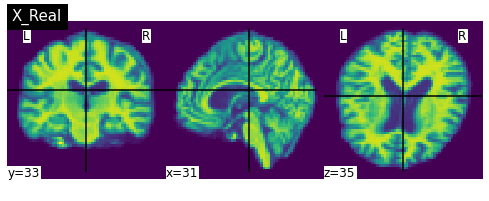

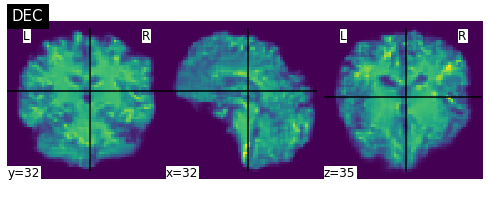

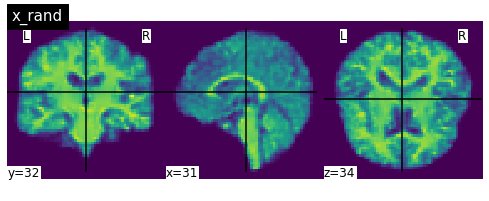

lossStr [73800/200000]
        D: -2.74   
        En_Ge: 1.83e+02


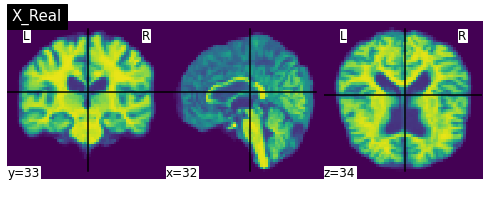

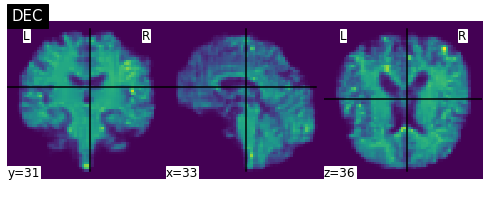

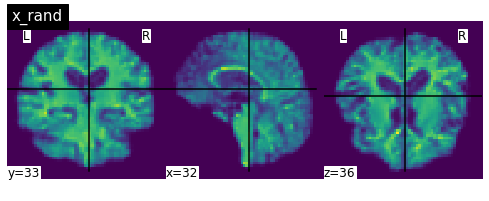

lossStr [73900/200000]
        D: -1.96   
        En_Ge: 1.89e+02


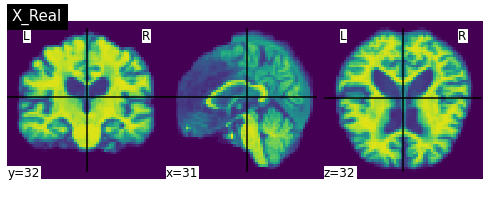

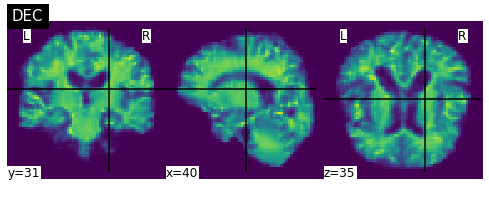

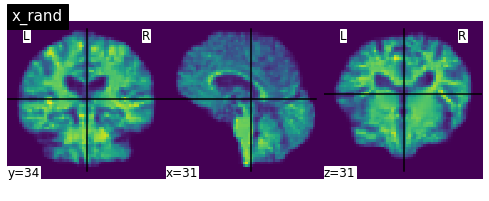

lossStr [74000/200000]
        D: -1.36   
        En_Ge: 1.91e+02


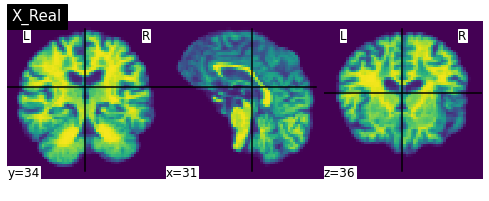

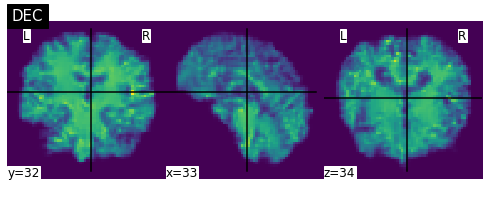

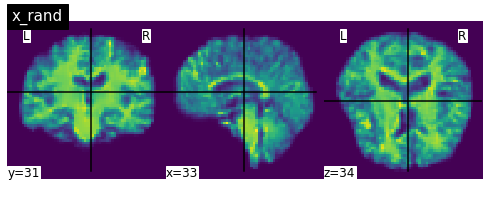

<Figure size 432x288 with 0 Axes>

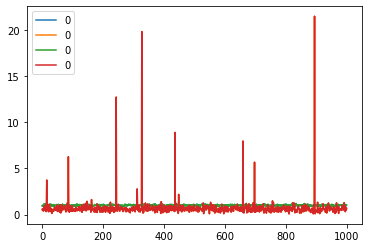

index: 74000, sample_mean: 0.01735156960785389 sample_var: 1.4771523475646973, yellow_mean: -0.0008893967024050653 yellow_var: 0.9988725185394287


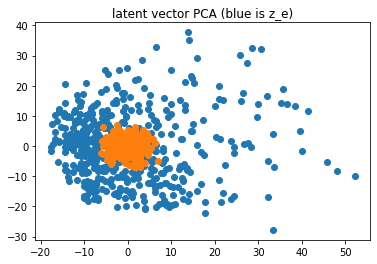

index: 74000, sample_mean: -0.8506357669830322 sample_var: 0.06161915510892868, yellow_mean: -0.8592367172241211 yellow_var: 0.05628350004553795


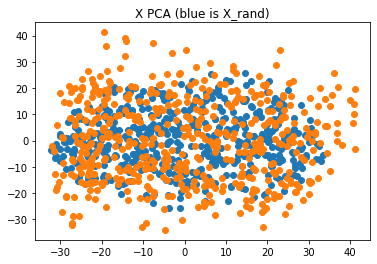

lossStr [74100/200000]
        D: -7.12   
        En_Ge: 1.81e+02


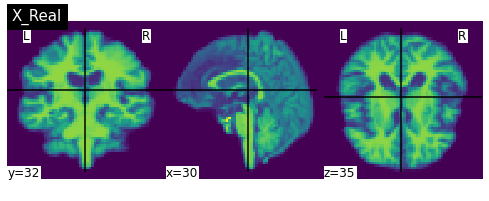

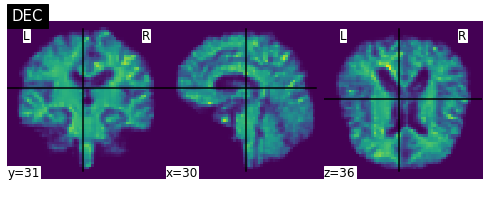

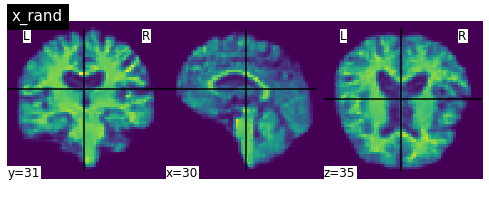

lossStr [74200/200000]
        D: -8.78   
        En_Ge: 1.96e+02


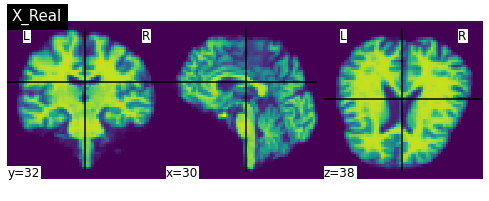

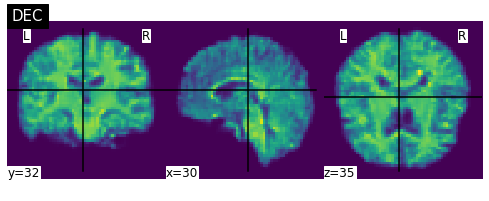

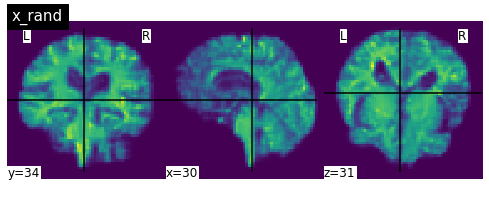

lossStr [74300/200000]
        D: -8.67   
        En_Ge: 1.84e+02


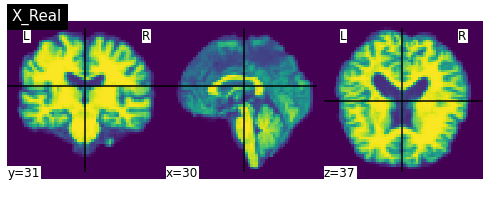

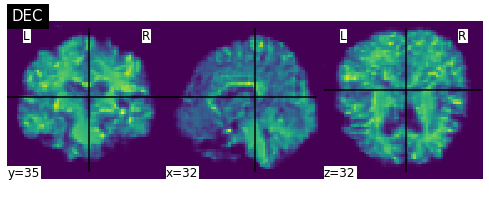

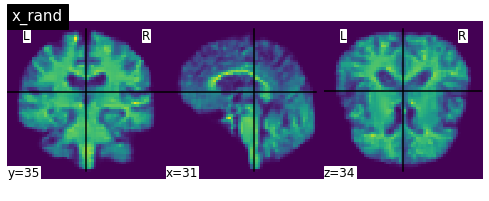

lossStr [74400/200000]
        D: -6.01   
        En_Ge: 1.92e+02


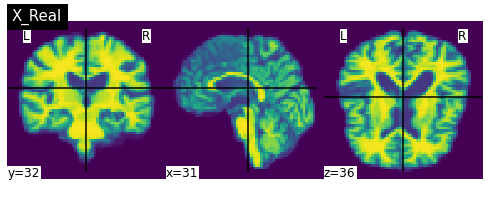

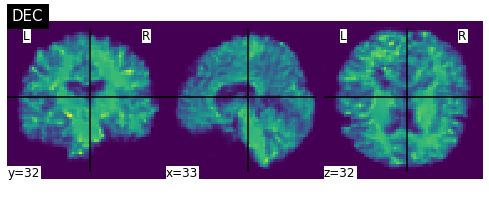

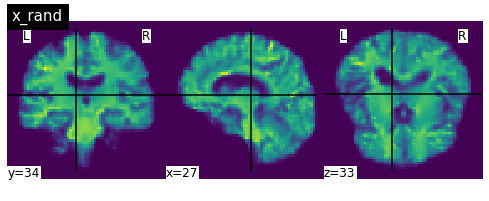

lossStr [74500/200000]
        D: -7.8    
        En_Ge: 2e+02   


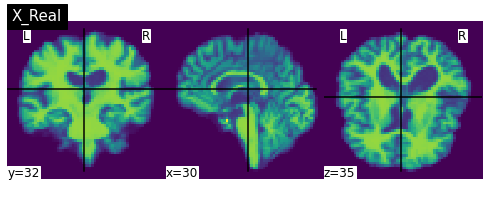

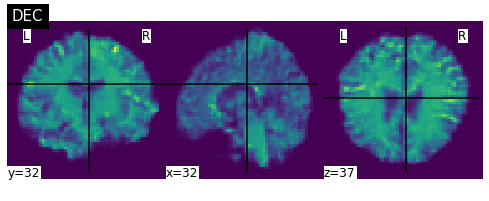

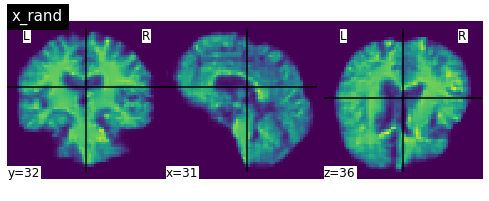

<Figure size 432x288 with 0 Axes>

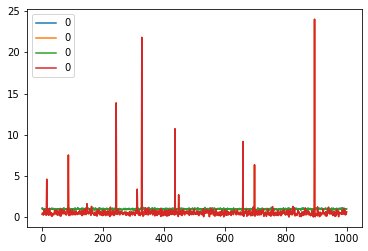

index: 74500, sample_mean: 0.05476359277963638 sample_var: 1.3499829769134521, yellow_mean: 0.00016465235967189074 yellow_var: 1.0017714500427246


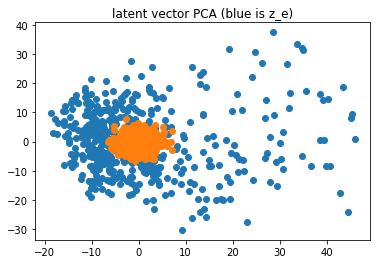

index: 74500, sample_mean: -0.8540165424346924 sample_var: 0.06123853474855423, yellow_mean: -0.8594632148742676 yellow_var: 0.05628115311264992


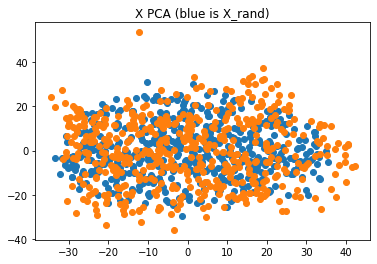

In [ ]:
# g_iter = 1
d_iter = 3
cd_iter =1
TOTAL_ITER = 200000
gen_load = inf_train_gen(train_loader)


while iteration <= TOTAL_ITER:
    for p in D.parameters():  
        p.requires_grad = False
    for p in CD.parameters():  
        p.requires_grad = False
    for p in E.parameters():  
        p.requires_grad = True
    for p in G.parameters():  
        p.requires_grad = True

    ###############################################
    # Train Encoder - Generator 
    ###############################################
    for iters in range(g_iter):
        G.zero_grad()
        E.zero_grad()
        real_images = gen_load.__next__().cuda(gpu_1)
        _batch_size = real_images.size(0)
        #remove Volatile Variable Usage
        real_images = real_images.cuda(gpu_1)
        
        z_rand = torch.randn((_batch_size,latent_dim)).cuda(gpu_0)
        z_hat = E(real_images).view(_batch_size,-1).cuda(gpu_0)
        x_hat = G(z_hat)
        x_rand = G(z_rand)
        
        ### wasserstein loss between z_e and z_r ###################
#         mmd_loss = 0.01 * latent_mmd(E, gen_load, batch_size=BATCH_SIZE, gpu_ind=gpu_1)
        w_dist = sp.sinkhorn_loss(torch.transpose(z_rand, 0, 1), torch.transpose(z_hat, 0, 1), 0.1, 1000, 100, gpu=gpu_0)
        ###############################################
        
        
#         c_loss = -1 * CD(z_hat.cuda(gpu_1)).mean() 
        d_real_loss = D(x_hat.cuda(gpu_0)).mean()
        d_fake_loss = D(x_rand.cuda(gpu_0)).mean()
        d_loss = -d_fake_loss-d_real_loss
        l1_loss = 10 * criterion_l1(x_hat.cuda(gpu_1),real_images) #original weight for L1 loss: 10
        loss1 = l1_loss + d_loss.cuda(gpu_1) + w_dist #original weight for c_loss: 1
         
        if iters<g_iter-1:
            loss1.backward()
        else:
            loss1.backward(retain_graph=True)
        g_optimizer.step()
        g_optimizer.step()
        e_optimizer.step() 
        
       
    ###############################################
    # Train D
    ###############################################
    for p in D.parameters():  
        p.requires_grad = True
    for p in CD.parameters():  
        p.requires_grad = False
    for p in E.parameters():  
        p.requires_grad = False
    for p in G.parameters():  
        p.requires_grad = False

    for iters in range(d_iter):
        d_optimizer.zero_grad()
        real_images = gen_load.__next__()
        _batch_size = real_images.size(0)
        #remove Volatile Variable
        z_rand = torch.randn((_batch_size,latent_dim)).cuda(gpu_0)
        real_images = real_images.cuda(gpu_1)
        z_hat = E(real_images).view(_batch_size,-1).cuda(gpu_0)
        x_hat = G(z_hat)
        x_rand = G(z_rand)
        real_images = real_images.cuda(gpu_0)
        x_loss2 = -2*D(real_images).mean()+D(x_hat).mean()+D(x_rand).mean()
        
        gradient_penalty_r = calc_gradient_penalty(D,real_images, x_rand, cuda_ind=gpu_1)
        gradient_penalty_h = calc_gradient_penalty(D,real_images, x_hat, cuda_ind=gpu_1)

        loss2 = x_loss2+gradient_penalty_r+gradient_penalty_h
        loss2.backward(retain_graph=True)
        d_optimizer.step()

    ###############################################
    # Train CD
    ###############################################
#     for p in D.parameters():  
#         p.requires_grad = False
#     for p in CD.parameters():  
#         p.requires_grad = True
#     for p in E.parameters():  
#         p.requires_grad = False
#     for p in G.parameters():  
#         p.requires_grad = False
        
#     for iters in range(cd_iter):
#         cd_optimizer.zero_grad()
#         #remove volatile Variable usage
#         z_rand = torch.randn((_batch_size,latent_dim)).cuda(gpu_1)
#         z_rand.requires_grad = False
        
#         gradient_penalty_cd = calc_gradient_penalty(CD,z_hat.cuda(gpu_1), z_rand, cuda_ind=gpu_1)
#         cd_zrand_loss = -CD(z_rand).mean()
#         loss3 = cd_zrand_loss - c_loss + gradient_penalty_cd
#         loss3.backward()
#         cd_optimizer.step()

    ###############################################
    # Visualization
    ###############################################

    if iteration % 100 == 0:
        lossStr = '[{}/{}]'.format(iteration,TOTAL_ITER) + '\n\
        D: {:<8.3}'.format(loss2.item()) + '\n\
        En_Ge: {:<8.3}'.format(loss1.item())
        
        print('lossStr', lossStr)
        feat = np.squeeze((0.5*real_images[0]+0.5).cpu().numpy())
        feat = nib.Nifti1Image(feat,affine = np.eye(4))
        
        plotting.plot_img(feat,title="X_Real")
        plotting.show()

        feat = np.squeeze((0.5*x_hat[0]+0.5).cpu().numpy())
        feat = nib.Nifti1Image(feat,affine = np.eye(4))
        plotting.plot_img(feat,title="DEC")
        
        feat = np.squeeze((0.5*x_rand[0]+0.5).data.cpu().numpy())
        feat = nib.Nifti1Image(feat,affine = np.eye(4))
        plotting.plot_img(feat,title="x_rand")
        plotting.show()
        
    ###############################################
    # Save the losses
    ###############################################
    loss_dict = {
        'index': [iteration],
        'l1_loss': [l1_loss.item()],
        'd_recon': [d_real_loss.item()],
        'd_fake': [d_fake_loss.item()],
        'd_real': [-2*D(real_images).mean().item()],
        'd_loss': [d_loss.item()],
#         'cd_loss': [c_loss.item()],
        'gp_r': [gradient_penalty_r.item()],
        'gp_h': [gradient_penalty_h.item()],
        'loss1': [loss1.item()],
        'loss2': [loss2.item()],
    }
    df = add_loss(df, loss_dict)
        

    ###############################################
    # Model Save
    ###############################################
    if iteration % 500 == 0 and iteration:
        torch.save(G.state_dict(),f'./{checkpoint_pth}/G_iter'+str(iteration)+'.pth')
        torch.save(D.state_dict(),f'./{checkpoint_pth}/D_iter'+str(iteration)+'.pth')
        torch.save(E.state_dict(),f'./{checkpoint_pth}/E_iter'+str(iteration)+'.pth')
#         torch.save(CD.state_dict(),f'./{checkpoint_pth}/CD_iter'+str(iteration)+'.pth')
        write_loss(df, path=checkpoint_pth)
        viz_pca(E, dataset, latent_size=latent_dim, index=iteration, is_cd=True, batch_size=1, gpu_ind=gpu_1)
        viz_pca(G, dataset, latent_size=latent_dim, index=iteration, gpu_ind=gpu_1, batch_size=4)
#         calc_mmd(train_loader, G, iteration, gpu_ind=gpu_1, path=checkpoint_pth)
        
        
    iteration += 1
   
    

In [ ]:
test = torch.tensor([[1, 2, 3], [15, 14, 13], [100, 80, 60]]).float()
test = torch.tensor([1, 2, 3, 4, 5, 6, 100]).float()
test = test.view(test.shape[0], -1)
print(test)
F.softmax(test, dim=0)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
%debug